#  XPCS   SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
x=1

In [2]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [3]:
#hdr = db[{{ uid }}]

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [5]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages
#register the fancy lazy chx eiger handler
from chxtools import handlers

### Lazy Eiger Handler (later will goto databroker)

In [6]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [7]:
#%matplotlib notebook
%matplotlib inline

### Get the events from the uid

In [8]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [9]:
uid = 'c423e856'
hdr = db[uid]

In [13]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/10/30/915b6fb3-aaf6-44f0-a999_9092_master.h5


In [14]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/10/30/'

In [15]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 2500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [16]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(0.00501, 0.0049999999)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [17]:
mask = np.load(uid+"_mask.npy")
#mask = np.load( path +  str(uid)+"_mask.npy"))

## Plot the mask

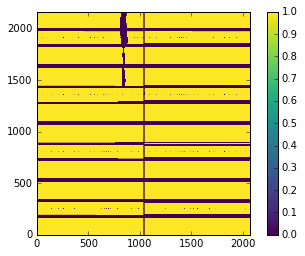

In [18]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

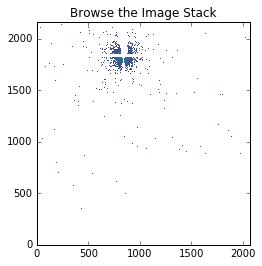

<function __main__.view_image>

In [19]:
from ipywidgets import interact

def view_image(i):
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e10 ) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, Nimg-1))

### hey, let's see if any images are bad!

In [20]:
bin_img = 25
imgsum = [np.sum(img *mask) for img in imgs[::bin_img]]

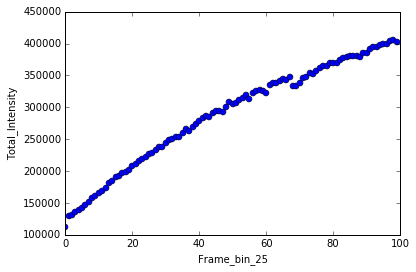

In [21]:
fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

### Get the Averaged Image Data

In [22]:
avg_img = np.average(imgs[::50], axis=0)*mask

## Plot the averged image with the mask

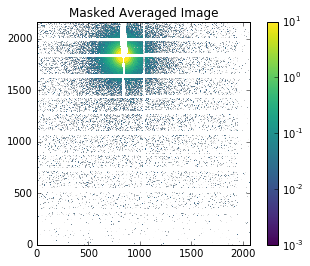

In [23]:
img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [26]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi

import skxray.core.correlation as corr
import skxray.core.utils as utils

## Get the approximate center and see the statistic to make sure 

In [27]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(840.0, 336.0)

In [28]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1830, 840]

## Create label array (Q rings)

In [29]:
inner_radius = 44  # radius of the first ring
width = 2       # width of each ring
spacing =  (119 - 44)/9 - 2    # spacing between rings
num_rings = 10   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  44.        ,   46.        ],
       [  52.33333333,   54.33333333],
       [  60.66666667,   62.66666667],
       [  69.        ,   71.        ],
       [  77.33333333,   79.33333333],
       [  85.66666667,   87.66666667],
       [  94.        ,   96.        ],
       [ 102.33333333,  104.33333333],
       [ 110.66666667,  112.66666667],
       [ 119.        ,  121.        ]])

In [30]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00307454,  0.0036439 ,  0.00421326,  0.00478262,  0.00535198,
        0.00592134,  0.00649069,  0.00706005,  0.00762941,  0.00819877])

In [31]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

## Extract the labeled array

In [32]:
ring_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
labels, indices = roi.extract_label_indices(ring_mask)

In [34]:
labels

array([10, 10, 10, ..., 10, 10, 10])

In [35]:
indices

array([3540525, 3540526, 3540527, ..., 4029094, 4031159, 4031160])

## Number of pixels in each q ring

In [36]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([ 222,  337,  458,  536,  661,  769,  879,  986, 1090, 1194])

# check center

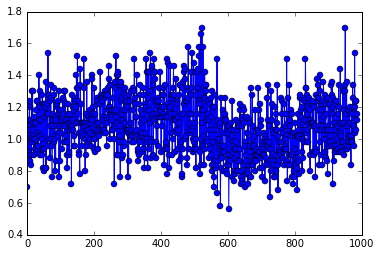

In [37]:
pixel = roi.roi_pixel_values(avg_img*mask, ring_mask, [8] )
fig, ax = plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )
plt.show()

## To mask the each image

In [38]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [39]:
masker = Masker(imgs, mask)

(1630, 2030)

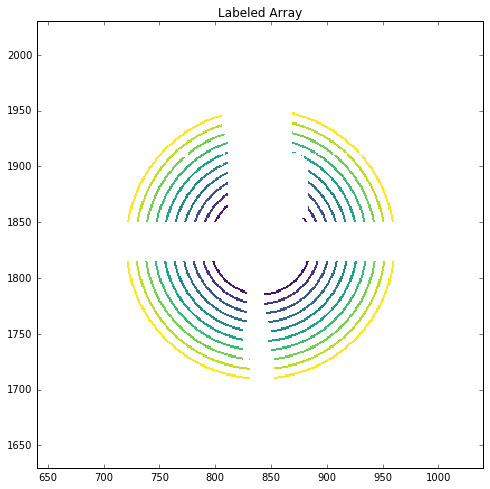

In [40]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 200 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])


##  Mean intensities for each ring

In [41]:
mask_data = masker[::50]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [42]:
mean_int_sets.shape

(50, 10)

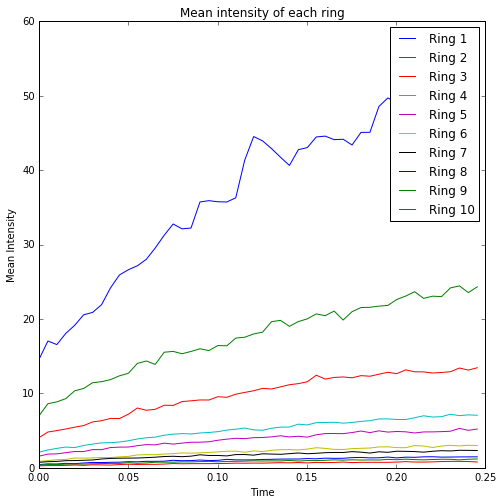

In [43]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [44]:
ring_mask = np.array( ring_mask, dtype=int)

In [68]:
num_lev = 4  # number of levels
num_buf = 8  # number of buffers

In [69]:
g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, imgs)

### Plot the one time correlation functions

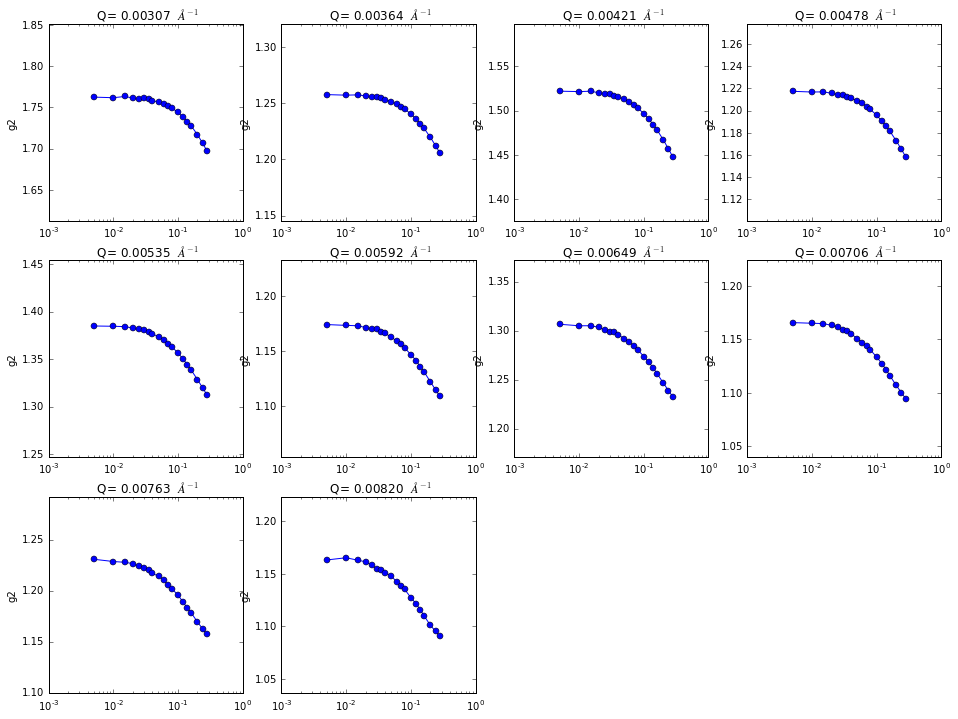

In [70]:
lags = lag_steps*timeperframe

sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y=g2[:, i]
    ax.semilogx(lags, y, '-o', markersize=6) 
    ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
plt.show()
fig.tight_layout()  

In [71]:
#from skxray.core.utils import multi_tau_lags
from skxray.core.roi import extract_label_indices
#from .mask import bad_to_nan_gen, threshold_mask
from collections import namedtuple
import logging
logger = logging.getLogger(__name__)


def _one_time_process(buf, G, past_intensity_norm, future_intensity_norm,
                      label_array, num_bufs, num_pixels, img_per_level,
                      level, buf_no, norm, lev_len):
    """Reference implementation of the inner loop of multi-tau one time
    correlation

    This helper function calculates G, past_intensity_norm and
    future_intensity_norm at each level, symmetric normalization is used.

    .. warning :: This modifies inputs in place.

    Parameters
    ----------
    buf : array
        image data array to use for correlation
    G : array
        matrix of auto-correlation function without normalizations
    past_intensity_norm : array
        matrix of past intensity normalizations
    future_intensity_norm : array
        matrix of future intensity normalizations
    label_array : array
        labeled array where all nonzero values are ROIs
    num_bufs : int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain ROI's
        ROI's, dimensions are : [number of ROI's]X1
    img_per_level : array
        to track how many images processed in each level
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number

    Notes
    -----
    :math ::
        G   = <I(\tau)I(\tau + delay)>
    :math ::
        past_intensity_norm = <I(\tau)>
    :math ::
        future_intensity_norm = <I(\tau + delay)>
    """
    img_per_level[level] += 1
    # in multi-tau correlation, the subsequent levels have half as many
    # buffers as the first
    i_min = num_bufs // 2 if level else 0
    for i in range(i_min, min(img_per_level[level], num_bufs)):
        # compute the index into the autocorrelation matrix
        t_index = level * num_bufs/ 2 + i
        delay_no = (buf_no - i) % num_bufs

        # get the images for correlating
        past_img = buf[level, delay_no]
        future_img = buf[level, buf_no]

        # find the normalization that can work both for bad_images
        #  and good_images
        ind = int(t_index - lev_len[:level].sum())
        normalize = img_per_level[level] - i - norm[level+1][ind]

        # To check the bad images,
        # bad images are converted to np.nan array
        if np.isnan(past_img).any() or np.isnan(future_img).any():
            norm[level + 1][ind] += 1
            normalize = img_per_level[level] - i - norm[level+1][ind]
        else:
            for w, arr in zip([past_img*future_img, past_img, future_img],
                              [G, past_intensity_norm, future_intensity_norm]):
                binned = np.bincount(label_array, weights=w)[1:]
                # pdb.set_trace()
                arr[t_index] += ((binned / num_pixels - arr[t_index]) / normalize)
    return None  # modifies arguments in place!


results = namedtuple(
    'correlation_results',
    ['g2', 'lag_steps', 'internal_state']
)

_internal_state = namedtuple(
    'correlation_state',
    ['buf',
     'G',
     'past_intensity',
     'future_intensity',
     'img_per_level',
     'label_array',
     'track_level',
     'cur',
     'pixel_list',
     'num_pixels',
     'lag_steps',
     'norm',
     'lev_len',
     ]
)

_two_time_internal_state = namedtuple(
    'two_time_correlation_state',
    [
    'buf',
    'img_per_level',
    'label_array',
    'track_level',
    'cur',
    'pixel_list',
    'num_pixels',
    'lag_steps',
    'g2',
    'count_level',
    'current_img_time',
    'time_ind',
    'norm',
    'lev_len',
    ]
)


def _init_state_one_time(num_levels, num_bufs, labels):
    """Initialize a stateful namedtuple for the generator-based multi-tau
     for one time correlation

    Parameters
    ----------
    num_levels : int
    num_bufs : int
    labels : array
        Two dimensional labeled array that contains ROI information

    Returns
    -------
    internal_state : namedtuple
        The namedtuple that contains all the state information that
        `lazy_one_time` requires so that it can be used to pick up
         processing after it was interrupted
    """
    (label_array, pixel_list, num_rois, num_pixels, lag_steps, buf,
     img_per_level, track_level, cur, norm,
     lev_len) = _validate_and_transform_inputs(num_bufs, num_levels, labels)

    # G holds the un normalized auto- correlation result. We
    # accumulate computations into G as the algorithm proceeds.
    G = np.zeros(((num_levels + 1) * num_bufs / 2, num_rois),
                 dtype=np.float64)
    # matrix for normalizing G into g2
    past_intensity = np.zeros_like(G)
    # matrix for normalizing G into g2
    future_intensity = np.zeros_like(G)

    return _internal_state(
        buf,
        G,
        past_intensity,
        future_intensity,
        img_per_level,
        label_array,
        track_level,
        cur,
        pixel_list,
        num_pixels,
        lag_steps,
        norm,
        lev_len,
    )


def lazy_one_time(image_iterable, num_levels, num_bufs, labels,
                  internal_state=None):
    """Generator implementation of 1-time multi-tau correlation

    If you do not want multi-tau correlation, set num_levels to 1 and
    num_bufs to the number of images you wish to correlate

    Parameters
    ----------
    image_iterable : iterable of 2D arrays
    num_levels : int
        how many generations of downsampling to perform, i.e., the depth of
        the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of downsampling
    labels : array
        Labeled array of the same shape as the image stack.
        Each ROI is represented by sequential integers starting at one.  For
        example, if you have four ROIs, they must be labeled 1, 2, 3,
        4. Background is labeled as 0
    labels : array
        Labeled array of the same shape as the image stack.
        Each ROI is represented by sequential integers starting at one.  For
        example, if you have four ROIs, they must be labeled 1, 2, 3,
        4. Background is labeled as 0
    internal_state : namedtuple, optional
        internal_state is a bucket for all of the internal state of the
        generator. It is part of the `results` object that is yielded from
        this generator

    Yields
    ------
    namedtuple
        A `results` object is yielded after every image has been processed.
         This `reults` object contains:
        - the normalized correlation, `g2`
        - the times at which the correlation was computed, `lag_steps`
        - and all of the internal state, `final_state`, which is a
          `correlation_state` namedtuple

    Notes
    -----
    The normalized intensity-intensity time-autocorrelation function
    is defined as

    :math ::
        g_2(q, t') = \frac{<I(q, t)I(q, t + t')> }{<I(q, t)>^2}

    ; t' > 0

    Here, I(q, t) refers to the scattering strength at the momentum
    transfer vector q in reciprocal space at time t, and the brackets
    <...> refer to averages over time t. The quantity t' denotes the
    delay time

    This implementation is based on published work. [1]_

    References
    ----------
    .. [1] D. Lumma, L. B. Lurio, S. G. J. Mochrie and M. Sutton,
        "Area detector based photon correlation in the regime of
        short data batches: Data reduction for dynamic x-ray
        scattering," Rev. Sci. Instrum., vol 70, p 3274-3289, 2000.
    """

    if internal_state is None:
        internal_state = _init_state_one_time(num_levels, num_bufs, labels)
    # create a shorthand reference to the results and state named tuple
    s = internal_state

    # iterate over the images to compute multi-tau correlation
    for image in image_iterable:
        # Compute the correlations for all higher levels.
        level = 0

        # increment buffer
        s.cur[0] = (1 + s.cur[0]) % num_bufs

        # Put the ROI pixels into the ring buffer.
        s.buf[0, s.cur[0] - 1] = np.ravel(image)[s.pixel_list]
        buf_no = s.cur[0] - 1
        # Compute the correlations between the first level
        # (undownsampled) frames. This modifies G,
        # past_intensity, future_intensity,
        # and img_per_level in place!
        _one_time_process(s.buf, s.G, s.past_intensity, s.future_intensity,
                          s.label_array, num_bufs, s.num_pixels,
                          s.img_per_level, level, buf_no, s.norm, s.lev_len)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        level = 1
        while processing:
            if not s.track_level[level]:
                s.track_level[level] = True
                processing = False
            else:
                prev = (1 + (s.cur[level - 1] - 2) % num_bufs)
                s.cur[level] = (
                    1 + s.cur[level] % num_bufs)

                s.buf[level, s.cur[level] - 1] = ((
                        s.buf[level - 1, prev - 1] +
                        s.buf[level - 1, s.cur[level - 1] - 1]) / 2)

                # make the track_level zero once that level is processed
                s.track_level[level] = False

                # call processing_func for each multi-tau level greater
                # than one. This is modifying things in place. See comment
                # on previous call above.
                buf_no = s.cur[level] - 1
                _one_time_process(s.buf, s.G, s.past_intensity,
                                  s.future_intensity, s.label_array, num_bufs,
                                  s.num_pixels, s.img_per_level, level, buf_no,
                                  s.norm, s.lev_len)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

        # If any past intensities are zero, then g2 cannot be normalized at
        # those levels. This if/else code block is basically preventing
        # divide-by-zero errors.
        if len(np.where(s.past_intensity == 0)[0]) != 0:
            g_max = np.where(s.past_intensity == 0)[0][0]
        else:
            g_max = s.past_intensity.shape[0]

        g2 = (s.G[:g_max] / (s.past_intensity[:g_max] *
                             s.future_intensity[:g_max]))
        yield results(g2, s.lag_steps[:g_max], s)


def multi_tau_auto_corr(num_levels, num_bufs, labels, images):
    """Wraps generator implementation of multi-tau

    Original code(in Yorick) for multi tau auto correlation
    author: Mark Sutton

    See docstring for lazy_one_time
    """
    gen = lazy_one_time(images, num_levels, num_bufs, labels)
    for result in gen:
        pass
    return result.g2, result.lag_steps


def auto_corr_scat_factor(lags, beta, relaxation_rate, baseline=1):
    """
    This model will provide normalized intensity-intensity time
    correlation data to be minimized.

    Parameters
    ----------
    lags : array
        delay time
    beta : float
        optical contrast (speckle contrast), a sample-independent
        beamline parameter
    relaxation_rate : float
        relaxation time associated with the samples dynamics.
    baseline : float, optional
        baseline of one time correlation
        equal to one for ergodic samples

    Returns
    -------
    g2 : array
        normalized intensity-intensity time autocorreltion

    Notes :
    -------
    The intensity-intensity autocorrelation g2 is connected to the intermediate
    scattering factor(ISF) g1

    :math ::
        g_2(q, \tau) = \beta_1[g_1(q, \tau)]^{2} + g_\infty

    For a system undergoing  diffusive dynamics,
    :math ::
        g_1(q, \tau) = e^{-\gamma(q) \tau}
    :math ::
       g_2(q, \tau) = \beta_1 e^{-2\gamma(q) \tau} + g_\infty

    These implementation are based on published work. [1]_

    References
    ----------
    .. [1] L. Li, P. Kwasniewski, D. Orsi, L. Wiegart, L. Cristofolini,
       C. Caronna and A. Fluerasu, " Photon statistics and speckle
       visibility spectroscopy with partially coherent X-rays,"
       J. Synchrotron Rad. vol 21, p 1288-1295, 2014

    """
    return beta * np.exp(-2 * relaxation_rate * lags) + baseline


def two_time_corr(labels, images, num_frames, num_bufs, num_levels=1):
    """Wraps generator implementation of multi-tau two time correlation

    This function computes two-time correlation
    Original code : author: Yugang Zhang

    See docstring for lazy_two_time
    """
    gen = lazy_two_time(labels, images, num_frames, num_bufs, num_levels)
    for result in gen:
        pass
    return two_time_state_to_results(result)


def lazy_two_time(labels, images, num_frames, num_bufs, num_levels=1,
                  two_time_internal_state=None):
    """ Generator implementation of two-time correlation

    If you do not want multi-tau correlation, set num_levels to 1 and
    num_bufs to the number of images you wish to correlate

    Multi-tau correlation uses a scheme to achieve long-time correlations
    inexpensively by downsampling the data, iteratively combining successive
    frames.

    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr

    Parameters
    ----------
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : iterable of 2D arrays
        dimensions are: (rr, cc), iterable of 2D arrays
    num_frames : int
        number of images to use
        default is number of images
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    num_levels : int, optional
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames
        default is one

    Yields
    ------
    internal_state : tuple
      all of the internal state, `final_state`, which is a
      `correlation_state` namedtuple

    Notes
    -----
    The two-time correlation function is defined as

    :math ::
        C(q, t_1, t_2) = \frac{<I(q, t_1)I(q, t_2)>_pix }{<I(q, t_1)>_pix <I(q, t_2)>_pix}

    Here, the ensemble averages are performed over many pixels of detector,
    all having the same q value. The average time or age is equal to (t1+t2)/2,
    measured by the distance along the t1 = t2 diagonal.
    The time difference t = |t1 - t2|, with is distance from the t1 = t2
    diagonal in the perpendicular direction.
    In the equilibrium system, the two-time correlation functions depend only
    on the time difference t, and hence the two-time correlation contour lines
    are parallel.

    References
    ----------

    .. [1] A. Fluerasu, A. Moussaid, A. Mandsen and A. Schofield,
        "Slow dynamics and aging in collodial gels studied by x-ray photon
         correlation spectroscopy," Phys. Rev. E., vol 76, p 010401(1-4), 2007.
    """
    if two_time_internal_state is None:
        two_time_internal_state = _init_state_two_time(num_levels, num_bufs,
                                                       labels, num_frames)
    # create a shorthand reference to the results and state named tuple
    s = two_time_internal_state

    for img in images:
        s.cur[0] = (1 + s.cur[0]) % num_bufs  # increment buffer

        s.count_level[0] = 1 + s.count_level[0]

        # get the current image time
        s = s._replace(current_img_time=(s.current_img_time + 1))

        # Put the image into the ring buffer.
        s.buf[0, s.cur[0] - 1] = (np.ravel(img))[s.pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time and img_per_level in place!
        _two_time_process(s.buf, s.g2, s.label_array, num_bufs,
                          s.num_pixels, s.img_per_level, s.lag_steps,
                          s.current_img_time, s.norm, s.lev_len,
                          level=0, buf_no=s.cur[0] - 1)

        # time frame for each level
        s.time_ind[0].append(s.current_img_time)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        # Compute the correlations for all higher levels.
        level = 1
        while processing:
            if not s.track_level[level]:
                s.track_level[level] = 1
                processing = False
            else:
                prev = 1 + (s.cur[level - 1] - 2) % num_bufs
                s.cur[level] = 1 + s.cur[level] % num_bufs
                s.count_level[level] = 1 + s.count_level[level]

                s.buf[level, s.cur[level] - 1] = (s.buf[level - 1, prev - 1] +
                                                  s.buf[level - 1,
                                                  s.cur[level - 1] - 1])/2

                t1_idx = (s.count_level[level] - 1) * 2

                current_img_time = ((s.time_ind[level - 1])[t1_idx] +
                                    (s.time_ind[level - 1])[t1_idx + 1])/2.

                # time frame for each level
                s.time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                s.track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(s.buf, s.g2, s.label_array, num_bufs,
                                  s.num_pixels, s.img_per_level, s.lag_steps,
                                  current_img_time, s.norm, s.lev_len,
                                  level=level, buf_no=s.cur[level]-1)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels
        yield s


def two_time_state_to_results(state):
    """Convert the internal state of the two time generator into usable results

    Parameters
    ----------
    state : namedtuple
        The internal state that is yielded from `lazy_two_time`

    Returns
    -------
    results : namedtuple
        A results object that contains the two time correlation results
        and the lag steps
    """
    for q in range(np.max(state.label_array)):
        x0 = (state.g2)[:, :, q]
        (state.g2)[:, :, q] = (np.tril(x0) + np.tril(x0).T -
                               np.diag(np.diag(x0)))
    return results(state.g2, state.lag_steps, state)


def _two_time_process(buf, g2, label_array, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, norm,
                      lev_len, level, buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation
    g2: array
        two time correlation matrix
    label_array: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    num_bufs: int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain ROI's
        ROI's, dimensions are : [number of ROI's]
    img_per_level: array
        to track how many images processed in each level
    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels
    current_img_time : int
        the current image number
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        t_index = level*num_bufs/2 + i

        delay_no = (buf_no - i) % num_bufs

        past_img = buf[level, delay_no]
        future_img = buf[level, buf_no]

        #  get the matrix of correlation function without normalizations
        tmp_binned = (np.bincount(label_array,
                                  weights=past_img*future_img)[1:])
        # get the matrix of past intensity normalizations
        pi_binned = (np.bincount(label_array,
                                 weights=past_img)[1:])

        # get the matrix of future intensity normalizations
        fi_binned = (np.bincount(label_array,
                                 weights=future_img)[1:])

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                g2[int(tind1+i),
                   int(tind2+i)] = (tmp_binned/(pi_binned *
                                                fi_binned))*num_pixels
        else:
            g2[tind1, tind2] = tmp_binned/(pi_binned * fi_binned)*num_pixels


def _init_state_two_time(num_levels, num_bufs, labels, num_frames):
    """Initialize a stateful namedtuple for two time correlation

    Parameters
    ----------
    num_levels : int
    num_bufs : int
    labels : array
        Two dimensional labeled array that contains ROI information
    num_frames : int
        number of images to use
        default is number of images
    Returns
    -------
    internal_state : namedtuple
        The namedtuple that contains all the state information that
        `lazy_two_time` requires so that it can be used to pick up processing
        after it was interrupted
    """
    (label_array, pixel_list, num_rois, num_pixels, lag_steps,
     buf, img_per_level, track_level, cur, norm,
     lev_len) = _validate_and_transform_inputs(num_bufs, num_levels, labels)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # current image time
    current_img_time = 0

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    # two time correlation results (array)
    g2 = np.zeros((num_frames, num_frames, num_rois), dtype=np.float64)

    return _two_time_internal_state(
        buf,
        img_per_level,
        label_array,
        track_level,
        cur,
        pixel_list,
        num_pixels,
        lag_steps,
        g2,
        count_level,
        current_img_time,
        time_ind,
        norm,
        lev_len,
    )


def _validate_and_transform_inputs(num_bufs, num_levels, labels):
    """
    This is a helper function to validate inputs and create initial state
    inputs for both one time and two time correlation

    Parameters
    ----------
    num_bufs : int
    num_levels : int
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    Returns
    -------
    label_array : array
        labels of the required region of interests(ROI's)
    pixel_list : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : int
        number of region of interests (ROI)
    num_pixels : array
        number of pixels in each ROI
    lag_steps : array
        the times at which the correlation was computed
    buf : array
        image data for correlation
    img_per_level : array
        to track how many images processed in each level
    track_level : array
        to track processing each level
    cur : array

    """
    if num_bufs % 2 != 0:
        raise ValueError("There must be an even number of `num_bufs`. You "
                         "provided %s" % num_bufs)
    label_array, pixel_list = extract_label_indices(labels)

    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n+1 for n, label in enumerate(np.unique(label_array))}
    # remap the label array to go from 1 -> max(_labels)
    for label, n in label_mapping.items():
        label_array[label_array == label] = n

    # number of ROI's
    num_rois = len(label_mapping)

    # stash the number of pixels in the mask
    num_pixels = np.bincount(label_array)[1:]

    # Convert from num_levels, num_bufs to lag frames.
    tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)

    norm = {key: [0] * len(dict_lag[key]) for key in list(dict_lag.keys())}
    lev_len = np.array([len(dict_lag[i]) for i in list(dict_lag.keys())])

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, len(pixel_list)),
                   dtype=np.float64)
    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)
    # to track which levels have already been processed
    track_level = np.zeros(num_levels, dtype=bool)
    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    return (label_array, pixel_list, num_rois, num_pixels,
            lag_steps, buf, img_per_level, track_level, cur,
            norm, lev_len)


def multi_tau_lags(multitau_levels, multitau_channels):
    """
    Standard multiple-tau algorithm for finding the lag times (delay
    times).

    Parameters
    ----------
    multitau_levels : int
        number of levels of multiple-taus
    multitau_channels : int
        number of channels or number of buffers in auto-correlators
        normalizations (must be even)

    Returns
    -------
    total_channels : int
        total number of channels ( or total number of delay times)
    lag_steps : ndarray
        delay or lag steps for the multiple tau analysis
    dict_lags : dict
        dictionary of delays for each multitau_levels

    Notes
    -----
    The multi-tau correlation scheme was used for finding the lag times
    (delay times).

    References: text [1]_

    .. [1] K. Schätzela, M. Drewela and  S. Stimaca, "Photon correlation
       measurements at large lag times: Improving statistical accuracy,"
       J. Mod. Opt., vol 35, p 711–718, 1988.
    """

    if (multitau_channels % 2 != 0):
        raise ValueError("Number of  multiple tau channels(buffers)"
                         " must be even. You provided {0} "
                         .format(multitau_channels))

    # total number of channels ( or total number of delay times)
    tot_channels = (multitau_levels + 1)*multitau_channels//2

    lag = []
    dict_lags = {}
    lag_steps = np.arange(0, multitau_channels)
    dict_lags[1] = lag_steps
    for i in range(2, multitau_levels + 1):
        y = []
        for j in range(0, multitau_channels//2):
            value = (multitau_channels//2 + j)*(2**(i - 1))
            lag.append(value)
            y.append(value)
        dict_lags[i] = y

    lag_steps = np.append(lag_steps, np.array(lag))
    return tot_channels, lag_steps, dict_lags



## include 4 bad images

In [72]:
bad_list = [4, 6, 167, 200]

In [73]:
def bad_to_nan_gen(image_gen, bad_list):
    """
    This generator will convert the bad image array in the images into
    NAN(Not-A-Number) array

    Parameters
    ----------
    image_gen : array
        image_iterable : iterable of 2D arrays
     : list
        bad images list

    Yields
    ------
    img : array
        if image is bad it will convert to np.nan array otherwise no
        change to the array
    """
    for n, im in enumerate(image_gen):
        if n in bad_list:
            yield np.nan*np.ones_like(im)
        else:
            yield im


In [79]:
img_new = bad_to_nan_gen(imgs, bad_list)


In [80]:

g2_n, lag_steps_n = multi_tau_auto_corr(num_lev, num_buf,
                                        ring_mask, img_new)

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:154: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:81: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [81]:
g2_n.shape, g2.shape

((20, 10), (20, 10))

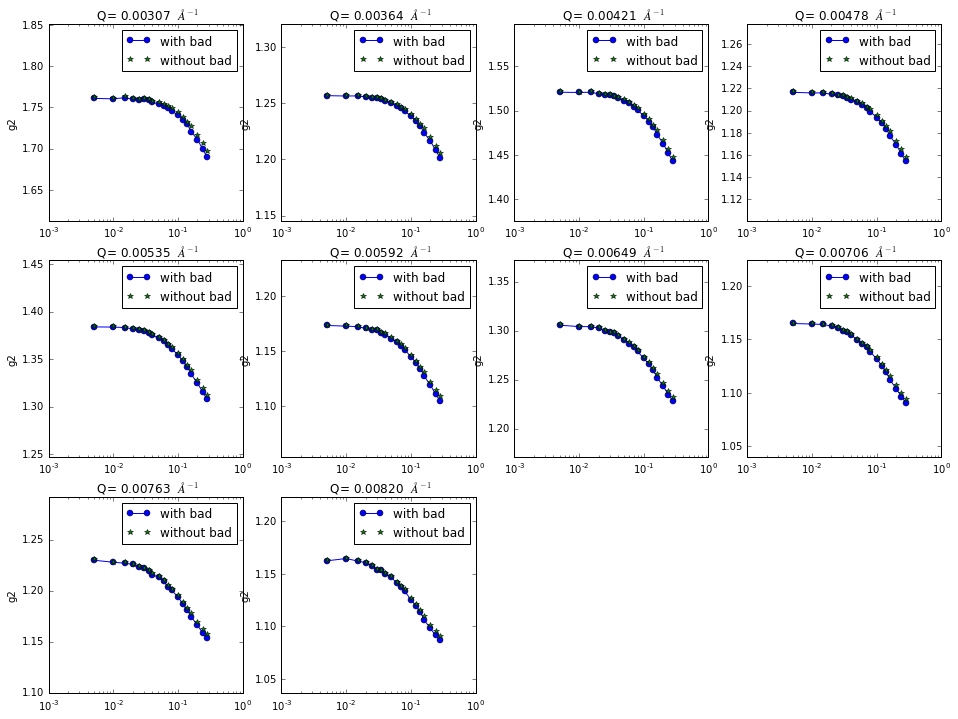

In [82]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y=g2_n[:, i]
    ax.semilogx(lags, y, '-o', markersize=6, label="with bad") 
    ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
    y1=g2[:, i]
    ax.semilogx(lags, y1, '*', markersize=6, label="without bad") 
    ax.set_ylim([min(y1)*.95, max(y1[1:])*1.05 ])
    ax.legend()
plt.show()
fig.tight_layout()  

In [84]:
len(imgs)

2500

##  Include 15 bad images

In [85]:
new_bad_list = [2, 30, 45, 67, 150, 268, 345, 980, 1080, 1500, 1980, 2080, 2100,  2345, 2490]

In [86]:
img_m = bad_to_nan_gen(imgs, new_bad_list)

In [87]:
g2_m, lag_steps_m = multi_tau_auto_corr(num_lev, num_buf,
                                        ring_mask, img_m)

/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:154: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda_envs/analysis/lib/python3.4/site-packages/IPython/kernel/__main__.py:81: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [88]:
g2_m.shape, g2.shape

((20, 10), (20, 10))

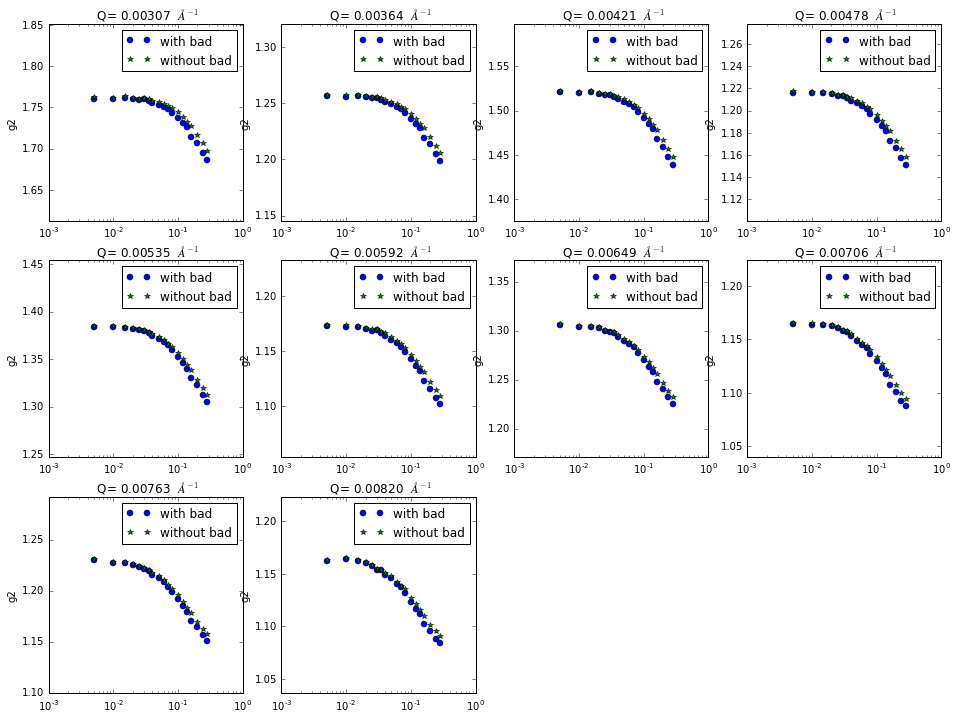

In [90]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y=g2_m[:, i]
    ax.semilogx(lags, y, 'o', markersize=6, label="with bad") 
    ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
    y1=g2[:, i]
    ax.semilogx(lags, y1, '*', markersize=6, label="without bad") 
    ax.set_ylim([min(y1)*.95, max(y1[1:])*1.05 ])
    ax.legend()
plt.show()
fig.tight_layout()  